In [81]:
import csv
# sim_dict
import hashlib
import itertools
import json
import re
import sys
import time
from collections import Counter
from datetime import datetime
from itertools import groupby
from operator import countOf

import en_core_web_lg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import tqdm
import wordninja
from fuzzywuzzy import process
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from thefuzz import fuzz
from tqdm import tqdm

from evaluator import evaluate
from file_output_layer import FileOutputLayer
from knowledge_layer import KnowledgeGroupLayer

input_dir = "../logs/"  # The input directory of log file
output_dir = "LogParserResult/"  # The output directory of parsing results

In [50]:
def remove_repeated(val):
    x = val.split(" ")
    str_list = list(filter(None, x))
    clean = [i[0] for i in groupby(str_list)]
    return " ".join(clean)


def preprocess_document(document):
    dic_debug = {}
    nlp = en_core_web_lg.load()
    # log_list =  [re.sub(r"[^A-Za-z]+", ' ', _) for _ in document]
    for log in document:
        splitted_log = wordninja.split(log.lower().rstrip())
        remove_urls = re.sub("[^ ]+\.[^ ]+", "<*>", " ".join(splitted_log))

        remove_float = re.sub("(\d*\.\d+)|(\d+\.[0-9 ]+)", "<*>", remove_urls)
        remove_int = re.sub(r"\d+", "<*>", remove_float)
        generic_str = re.sub(r"\b\w{1,2}\b", "", remove_int)

        dic_debug[log] = remove_repeated(generic_str)
    logs_clean = dic_debug.values()
    return logs_clean, dic_debug

In [40]:
def compute_generic_string(dataset):
    # edge case where all strings are the same
    if len(set(dataset)) == 1:
        return dataset[0]
    commonprefix = os.path.commonprefix(dataset)

    return "{}<*> {}".format(
        commonprefix,
        os.path.commonprefix([s[len(commonprefix) :][::-1] for s in dataset])[::-1],
    )


def transform_wildcard(document, doc_dic):
    print("in wild card step")
    # print(doc_dic.values())

    logs_clean = list(set(document))  # remove repeated logs
    print(len(logs_clean))
    for doc1, doc2 in tqdm(
        itertools.combinations(logs_clean, 2), desc="processing similar logs" ):

        pair = [doc1, doc2]
        ratio = fuzz.ratio(doc1, doc2)

        if ratio > 85:
            c = compute_generic_string(pair)
            if c not in doc_dic.values():
                p_string = c
                # removing old template from dictionary
                # print(pair, p_string)
                log_key1 = next(
                    (log for log, template in doc_dic.items() if template == doc1), None
                )
                log_key2 = next(
                    (log for log, template in doc_dic.items() if template == doc2), None
                )
                doc_dic.update({log_key1: p_string, log_key2: p_string})

    return list(set(doc_dic.values())), doc_dic

In [6]:
def get_relations(document, doc_dic):
    # in our case, relations are bigrams in sentences
    bigrams = []
    nlp = en_core_web_lg.load()
    # for sent in document:

    print("in get relation step ", len(document))
    for i in range(len(document) - 1):
        if doc_dic[document[i]] != doc_dic[document[i + 1]]:
            pair = (doc_dic[document[i]], doc_dic[document[i + 1]])
            if pair not in bigrams:
                bigrams.append(pair)

    return bigrams

In [39]:
def build_graph(doc):
    # preprocess document for standardization

    start_time = time.time()
    pdoc, dic_rel = preprocess_document(doc)
    # get graph nodes
    pdoc, dic_rel = transform_wildcard(pdoc, dic_rel)
    # print(dic_rel)
    print("--- %s seconds ---" % (time.time() - start_time))
    edges = get_relations(doc, dic_rel)

    # print(pdoc)
    # get graph edges
    if "<*>" in pdoc:
        pdoc.remove("<*>")
    # print(json.dumps(dic_rel, indent=4))
    # nodes = log_transformer(pdoc)
    # create graph structure with NetworkX
    G = nx.Graph()
    G.add_nodes_from(pdoc)
    atrributes = Counter(pdoc)
    nx.set_node_attributes(G, atrributes, "count")
    G.add_edges_from(edges)

    G.remove_edges_from(nx.selfloop_edges(G))

    return G, dic_rel

In [10]:
benchmark_settings = {
    "HDFS": {
        "log_file": "HDFS/HDFS_2k.log",
        "log_format": "<Date> <Time> <Pid> <Level> <Component>: <Content>",
    },
    "Hadoop": {
        "log_file": "Hadoop/Hadoop_2k.log",
        "log_format": "<Date> <Time> <Level> \[<Process>\] <Component>: <Content>",
    },
    "Spark": {
        "log_file": "Spark/Spark_2k.log",
        "log_format": "<Date> <Time> <Level> <Component>: <Content>",
    },
    "Zookeeper": {
        "log_file": "Zookeeper/Zookeeper_2k.log",
        "log_format": "<Date> <Time> - <Level>  \[<Node>:<Component>@<Id>\] - <Content>",
    },
    "BGL": {
        "log_file": "BGL/BGL_2k.log",
        "log_format": "<Label> <Timestamp> <Date> <Node> <Time> <NodeRepeat> <Type> <Component> <Level> <Content>",
    },
    "HPC": {
        "log_file": "HPC/HPC_2k.log",
        "log_format": "<LogId> <Node> <Component> <State> <Time> <Flag> <Content>",
    },
    "Thunderbird": {
        "log_file": "Thunderbird/Thunderbird_2k.log",
        "log_format": "<Label> <Timestamp> <Date> <User> <Month> <Day> <Time> <Location> <Component>(\[<PID>\])?: <Content>",
    },
    "Windows": {
        "log_file": "Windows/Windows_2k.log",
        "log_format": "<Date> <Time>, <Level>                  <Component>    <Content>",
    },
    "Linux": {
        "log_file": "Linux/Linux_2k.log",
        "log_format": "<Month> <Date> <Time> <Level> <Component>(\[<PID>\])?: <Content>",
    },
    "Andriod": {
        "log_file": "Andriod/Andriod_2k.log",
        "log_format": "<Date> <Time>  <Pid>  <Tid> <Level> <Component>: <Content>",
    },
    "HealthApp": {
        "log_file": "HealthApp/HealthApp_2k.log",
        "log_format": "<Time>\|<Component>\|<Pid>\|<Content>",
    },
    "Apache": {
        "log_file": "Apache/Apache_2k.log",
        "log_format": "\[<Time>\] \[<Level>\] <Content>",
    },
    "Proxifier": {
        "log_file": "Proxifier/Proxifier_2k.log",
        "log_format": "\[<Time>\] <Program> - <Content>",
    },
    "OpenSSH": {
        "log_file": "OpenSSH/OpenSSH_2k.log",
        "log_format": "<Date> <Day> <Time> <Component> sshd\[<Pid>\]: <Content>",
    },
    "OpenStack": {
        "log_file": "OpenStack/OpenStack_2k.log",
        "log_format": "<Logrecord> <Date> <Time> <Pid> <Level> <Component> \[<ADDR>\] <Content>",
    },
    "Mac": {
        "log_file": "Mac/Mac_2k.log",
        "log_format": "<Month>  <Date> <Time> <User> <Component>\[<PID>\]( \(<Address>\))?: <Content>",
    },
}

In [11]:
def load_logs(log_file, regex, headers):
    """ Function to transform log file to dataframe
    """
    log_messages = dict()
    linecount = 0
    with open(log_file, "r") as fin:
        for line in tqdm(fin.readlines(), desc="load data"):
            try:
                linecount += 1
                match = regex.search(line.strip())
                message = dict()
                for header in headers:
                    message[header] = match.group(header)
                message["LineId"] = linecount
                log_messages[linecount] = message
            except Exception as e:
                pass
    return log_messages


def generate_logformat_regex(logformat):
    """ Function to generate regular expression to split log messages
    """
    headers = []
    splitters = re.split(r"(<[^<>]+>)", logformat)
    regex = ""
    for k in range(len(splitters)):
        if k % 2 == 0:
            splitter = re.sub(" +", "\\\s+", splitters[k])
            regex += splitter
        else:
            header = splitters[k].strip("<").strip(">")
            regex += "(?P<%s>.*?)" % header
            headers.append(header)
    regex = re.compile("^" + regex + "$")
    return headers, regex

In [42]:
def plot_graph(G, title=None):
    # set figure size
    plt.figure(figsize=(10, 10))

    # define position of nodes in figure
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    pos = nx.nx_agraph.graphviz_layout(G)

    # draw nodes and edges
    nx.draw(G, pos=pos, with_labels=True)

    # draw edge labels (if any)
    # nx.draw_networkx_nodes(G, pos, edge_labels=edge_labels)
    nx.draw_networkx_nodes(G, pos)

    plt.show()
    return

In [70]:
dataset = "HDFS"
filepath = "logs/" + benchmark_settings[dataset]["log_file"]
print("Parsing file: " + filepath)
starttime = datetime.now()
headers, regex = generate_logformat_regex(benchmark_settings[dataset]["log_format"])
log_messages = load_logs(filepath, regex, headers)
# preprocess layer
log_messages = KnowledgeGroupLayer(log_messages).run()
list_dict = log_messages.values()
logs = [d.get("Content", None) for d in list_dict]

priori knowledge preprocess: 100%|██████████| 2000/2000 [00:00<00:00, 24161.15it/s]

Parsing file: logs/HDFS/HDFS_2k.log
Knowledge group layer finished.


processing similar logs: 190it [00:00, 63443.81it/s]

in wild card step
20
--- 3.8755886554718018 seconds ---


in get relation step  2000


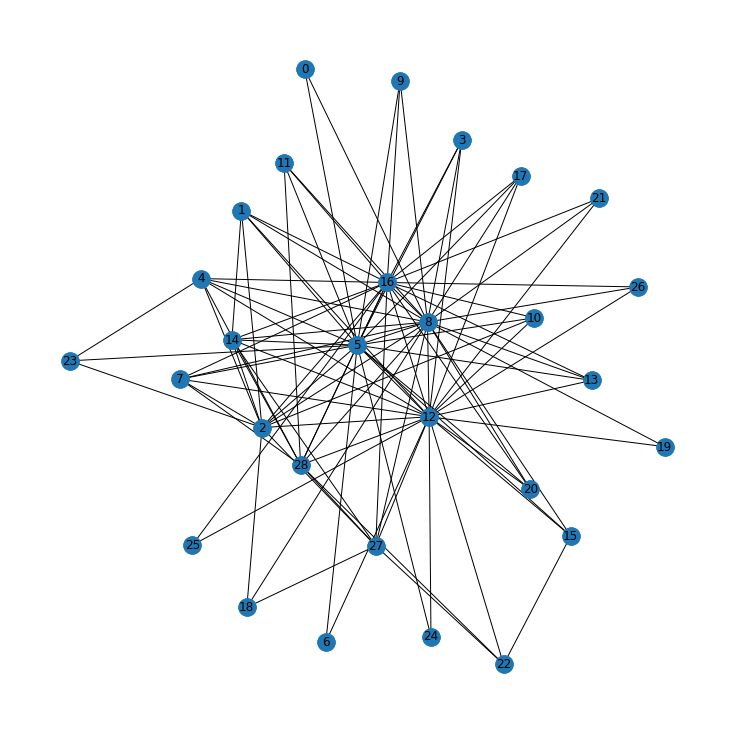

In [71]:
G, dict_out = build_graph(logs)
plot_graph(G)

In [72]:
nx.write_gpickle(G, dataset + "_Bigram.gpickle")

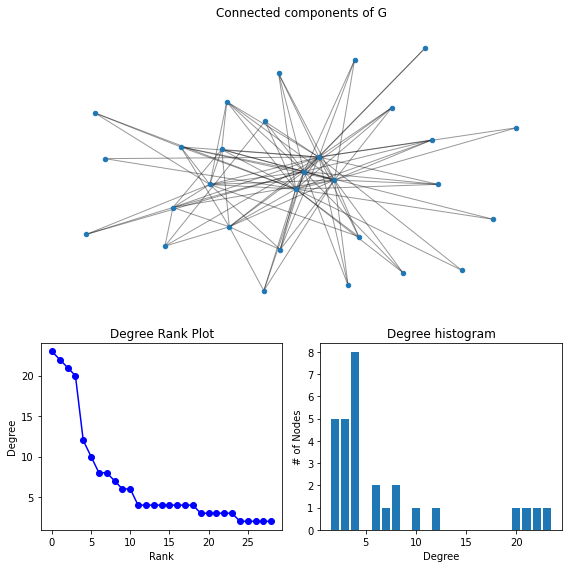

In [73]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [ ]:
templates = list(set(G.nodes()))
dirname = "results/" + dataset + ".csv"
df = pd.DataFrame(data={"template": templates})
df.to_csv(dirname, sep=",", index=False)
sys.path.insert(1, os.path.join(sys.path[0], ".."))


output_file = "results/" + dataset


def add_template_id(path):
    df = pd.read_csv(path)
    # df.pop(df.columns[0])
    your_list = df.EventTemplate.to_list()
    dict_df = dict(zip(df.EventTemplate, df.EventId))

    sim_dict = {}
    for element in G.nodes():

        a = process.extractOne(element, your_list)
        sim_dict[element] = dict_df.get((a)[0], None)
        # sim_list.append(element)
        # sim_list.append(dict_df[(a)[0]])
    return sim_dict


sim_dict = add_template_id(
    "../log_parser/logs/" + dataset + "/" + dataset + "_2k.log_templates.csv"
)


def output_csv(filename, messages, headers):
    with open(filename, "w", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)
        writer.writeheader()
        for key, row in messages.items():
            writer.writerow(row)


log_events = dict()
event_tot = 0
message_headers = headers + ["LineId"]
# for key in logs[0:10]:
# eid = hashlib.md5(key.encode('utf-8')).hexdigest()[0:8]
for logid in log_messages:
    cur_template = dict_out[log_messages[logid]["Content"]]
    log_messages[logid]["EventTemplate"] = cur_template
    log_messages[logid]["EventId"] = sim_dict[cur_template]
    log_events[event_tot] = dict(
        EventId=sim_dict[cur_template],
        EventTemplate=cur_template,
        Occurrences=countOf(dict_out.values(), cur_template),
    )
    event_tot += 1
message_headers += ["EventId", "EventTemplate"]
event_headers = ["EventId", "EventTemplate", "Occurrences"]

output_csv(output_file + "_structured.csv", log_messages, message_headers)
# output_csv(output_file+'_templates.csv', log_events, event_headers)
# outdir ='\Spark_structured.csv
F1_measure, accuracy = evaluate(
    groundtruth=os.path.join(
        "logs/" + dataset + "/" + dataset + "_2k.log_structured.csv"
    ),
    parsedresult=os.path.join("results", dataset + "_structured.csv"),
)